In [1]:
import os
import glob
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans
from sklearn import metrics

%matplotlib inline

## Using Word Embeddings

In [9]:
cats = ['art', 'gaming', 'music', 'politics_news', 'science', 'sports', 'tech']
stem = 'lemma'

In [10]:
documents = []

for cat in cats:
    os.chdir(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        df = pd.DataFrame(comments)
        posts = df['post_id'].unique()
        for post in posts:
            documents.append((' '.join(list(df[df['post_id'] == post]['comment'])), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [11]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

**Using Gensim**

In [12]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [13]:
os.chdir(r'C:\Users\jonat\Desktop\Data Mining\Project\Data')

model = Doc2Vec.load('posts.model')

doc_vectors = []
for i in range(0, len(documents)):
    doc_vectors.append(model[str(i)])

doc_vectors = np.array(doc_vectors)
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

pca = PCA(n_components=2)
pca.fit(doc_scaled)

X_plot = pca.transform(doc_scaled)

In [14]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, 100))
labels = np.array(documents[:, 2], dtype=int)

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(doc_scaled)
    sill.append(metrics.silhouette_score(doc_vectors, labels=km.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, km.labels_))
    com.append(metrics.completeness_score(labels, km.labels_))
    v.append(metrics.v_measure_score(labels, km.labels_))

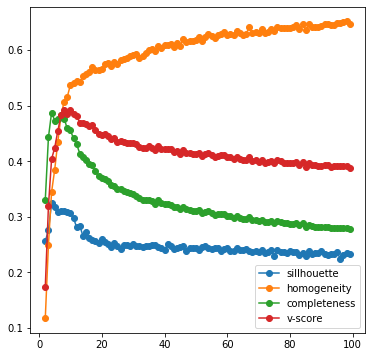

In [15]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sill, marker='o', label='sillhouette')
plt.plot(list_k, homo, marker='o', label='homogeneity')
plt.plot(list_k, com, marker='o', label='completeness')
plt.plot(list_k, v, marker='o', label='v-score')
plt.legend()

Let's choose the value of k that can maximize our v-score:

In [16]:
mapping = np.array(list(zip(list_k, v)))
k = int(mapping[np.where(mapping[:, 1] == max(mapping[:, 1]))[0][0]][0])

Silhouette score: 0.311210960149765
Homogeneity: 0.537
Completeness: 0.455
V-measure: 0.493
Inertia: 2488.818145552861



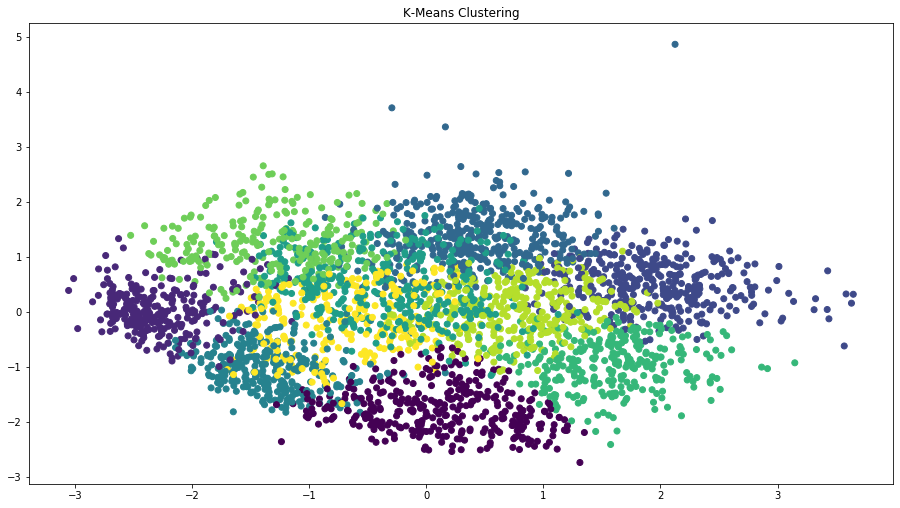

In [17]:
km = KMeans(n_clusters=k)
km.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=km.labels_)
    
ax.set_title('K-Means Clustering')

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=km.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print(f'Inertia: {km.inertia_}\n')

**Agglomerative Clustering**

In [18]:
from sklearn.cluster import AgglomerativeClustering

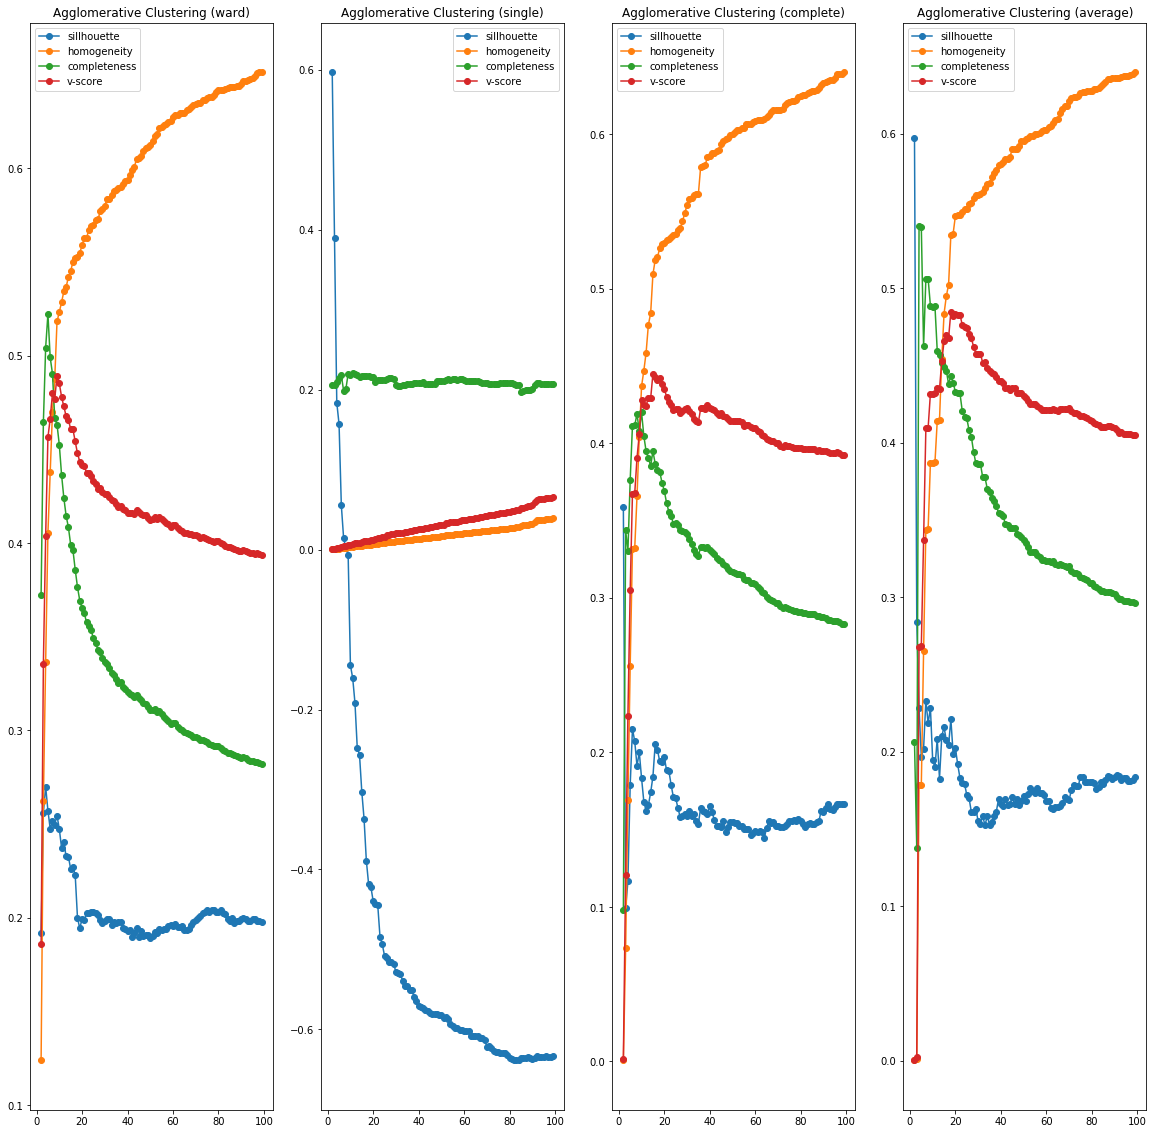

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=[20, 20])
linkages = ['ward', 'single', 'complete', 'average']
list_k = list(range(2, 100))

for i, axis in enumerate(ax):
    sill = []
    homo=[]
    com = []
    v=[]
    for k in list_k:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkages[i])
        agg.fit(doc_scaled)
        sill.append(metrics.silhouette_score(doc_vectors, labels=agg.labels_.reshape(-1)))
        homo.append(metrics.homogeneity_score(labels, agg.labels_))
        com.append(metrics.completeness_score(labels, agg.labels_))
        v.append(metrics.v_measure_score(labels, agg.labels_))

    axis.plot(list_k, sill, marker='o', label='sillhouette')
    axis.plot(list_k, homo, marker='o', label='homogeneity')
    axis.plot(list_k, com, marker='o', label='completeness')
    axis.plot(list_k, v, marker='o', label='v-score')
    axis.legend()
    axis.set_title(f'Agglomerative Clustering ({linkages[i]})')

In [20]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, 100))
for k in list_k:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg.fit(doc_scaled)
    sill.append(metrics.silhouette_score(doc_vectors, labels=agg.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, agg.labels_))
    com.append(metrics.completeness_score(labels, agg.labels_))
    v.append(metrics.v_measure_score(labels, agg.labels_))

Again, go for maximizing v-score:

In [21]:
mapping = np.array(list(zip(list_k, v)))
k = int(mapping[np.where(mapping[:, 1] == max(mapping[:, 1]))[0][0]][0])

Silhouette score: 0.2490939348936081
Homogeneity: 0.518
Completeness: 0.463
V-measure: 0.489


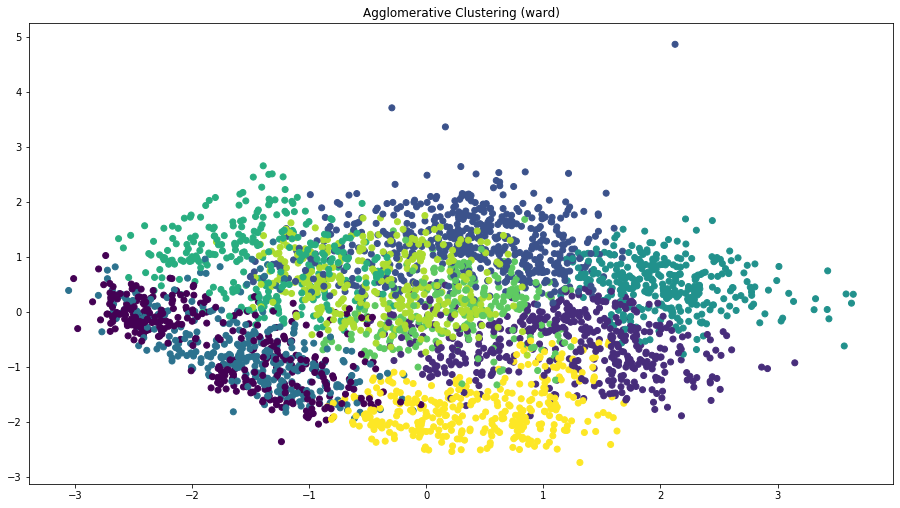

In [22]:
agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
agg.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=agg.labels_)
    
ax.set_title('Agglomerative Clustering (ward)')

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=agg.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, agg.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, agg.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, agg.labels_))

**OPTICS**

In [24]:
from sklearn.cluster import OPTICS

Silhouette score: -0.46606695652008057
Homogeneity: 0.196
Completeness: 0.211
V-measure: 0.203


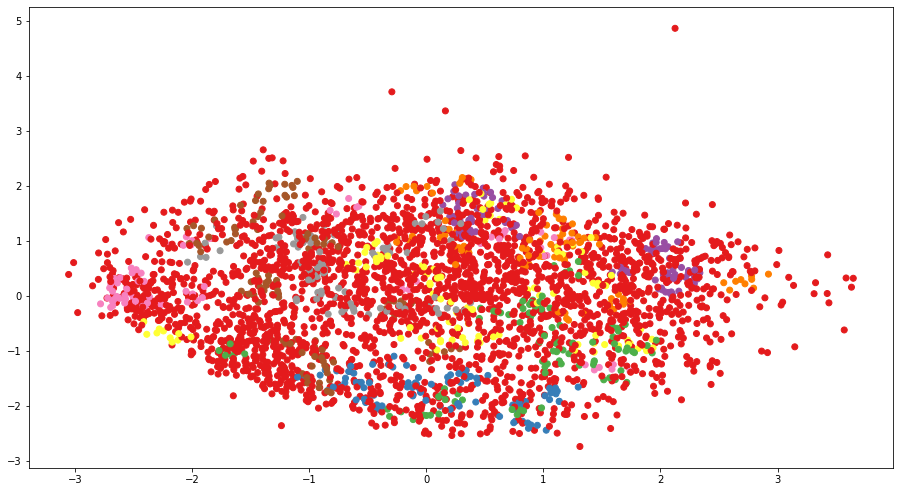

In [25]:
op = OPTICS()
op.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=op.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=op.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, op.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, op.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, op.labels_))

That's about as bad as we could possibly get.

**Affinity Propagation**

In [26]:
from sklearn.cluster import AffinityPropagation

Silhouette score: 0.23875939846038818
Homogeneity: 0.635
Completeness: 0.289
V-measure: 0.397


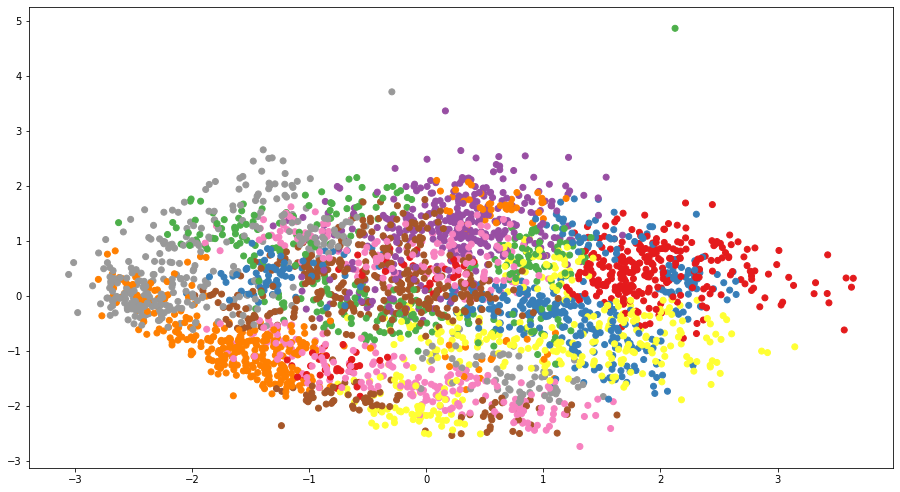

In [27]:
af = AffinityPropagation()
af.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=af.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=af.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, af.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, af.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, af.labels_))

Homogeneity here is really good!  However, we can see that there are a ton of overlapping clusters that bring down the sillhouette score; completeness is poor, but it may not necessarily be a big deal for making recommendations.

**Spectral Clustering**

In [28]:
from sklearn.cluster import SpectralClustering

In [31]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, 100))
for k in list_k:
    sc = SpectralClustering(n_clusters=k)
    sc.fit(doc_scaled)
    sill.append(metrics.silhouette_score(doc_vectors, labels=sc.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, sc.labels_))
    com.append(metrics.completeness_score(labels, sc.labels_))
    v.append(metrics.v_measure_score(labels, sc.labels_))

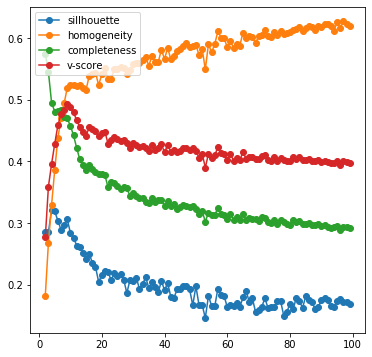

In [32]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sill, marker='o', label='sillhouette')
plt.plot(list_k, homo, marker='o', label='homogeneity')
plt.plot(list_k, com, marker='o', label='completeness')
plt.plot(list_k, v, marker='o', label='v-score')
plt.legend()

In [33]:
mapping = np.array(list(zip(list_k, v)))
k = int(mapping[np.where(mapping[:, 1] == max(mapping[:, 1]))[0][0]][0])

Silhouette score: 0.30562853813171387
Homogeneity: 0.519
Completeness: 0.470
V-measure: 0.493


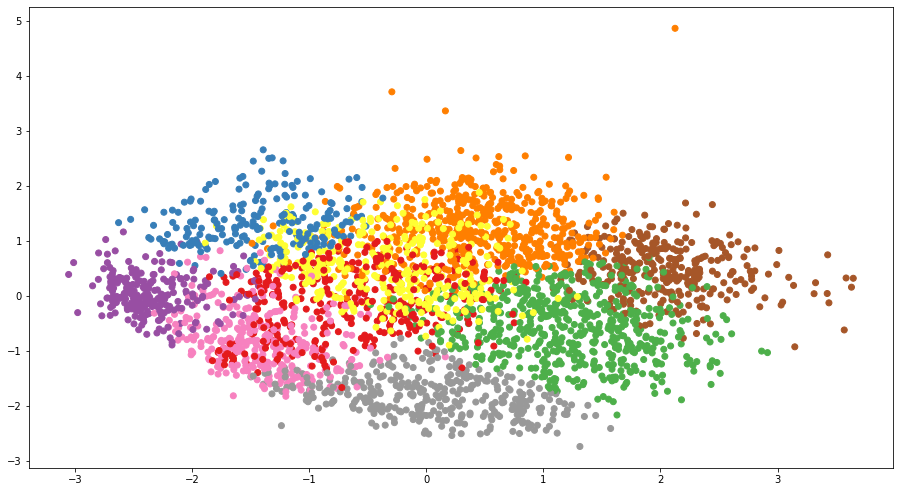

In [35]:
sc = SpectralClustering(n_clusters=k)
sc.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=sc.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=sc.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, sc.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, sc.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, sc.labels_))

## Application

In [23]:
docs = list(documents[:, 0])
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(docs)]

In [36]:
doc_id = random.randint(0, len(tagged_data) - 1)
inferred_vector = model.infer_vector(tagged_data[doc_id][0])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

indexes = np.array(sims[1:11], dtype=int)[:, 0]

print(f'Sample subreddit: {documents[doc_id][3]}')
print(f'Sample category: {documents[doc_id][1]}')

Sample subreddit: psychology
Sample category: science


Let's look at the category of the closest posts to the one we got from r/psychology:

In [37]:
for index in indexes:
    print(documents[index][3])

psychology
psychology
psychology
science
science
tech
futurology
science
futurology
science


The top three are other posts in the psychology sub!  There are also a lot of science and tech subs represented as well.  Now let's use our models to find the subs corresponding to the posts in the same cluster as ours:

In [38]:
cluster = km.predict([doc_scaled[doc_id]])[0]
same_cluster_index = np.where(km.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

games
games
games
games
gaming
gaming
gaming
gaming
pcgaming
pcgaming
pcgaming
pcgaming
ps4
xboxone
news
news
news
news
news
news
news
news
news
news
news
news
news
news
news
news
news
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
chemistry
chemistry
physics
physics
physics
physics
physics
physics
physics
physics
physics
physics
physics
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psycholo

Not going to lie, a lot of these are awful recommendations (without looking at what each post is actually about).  Let's see if any other models can produce meaningful recommendations:

In [39]:
cluster = agg.labels_[doc_id]
same_cluster_index = np.where(agg.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

games
games
games
games
gaming
gaming
gaming
pcgaming
pcgaming
ps4
ps4
guitar
news
news
news
news
news
news
news
PoliticalHumor
PoliticalHumor
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
chemistry
physics
physics
physics
physics
physics
physics
physics
physics
physics
physics
physics
physics
physics
physics
physics
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psycholo

In [40]:
cluster = af.labels_[doc_id]
same_cluster_index = np.where(af.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

gaming
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
chemistry
physics
physics
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
science
science
science
science
science
science
futurology
futurology
gadgets
tech
tech


This cluster is smaller and includes a lot of posts from r/science and r/psychology, as well as other science and tech subs.  This clustering seems to have greater topic coherence than any others so far.

In [41]:
cluster = sc.labels_[doc_id]
same_cluster_index = np.where(sc.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

games
games
games
games
gaming
pcgaming
pcgaming
pcgaming
ps4
xboxone
news
news
news
news
news
news
news
news
news
news
news
news
news
news
news
news
news
news
news
news
news
news
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
PoliticalHumor
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
worldnews
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
biology
chemistry
physics
physics
physics
physics
physics
physics
physics
physics
physics
physics
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychology
psychol

And another mixed bag here.  It looks like our model has a bit of a tough time keeping its topics coherent within clusters.

## Without using word embeddings

In [42]:
documents = []

for cat in cats:
    os.chdir(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        df = pd.DataFrame(comments)
        posts = df['post_id'].unique()
        for post in posts:
            documents.append((' '.join(list(df[df['post_id'] == post]['comment'])), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [43]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

In [44]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X_plot = tfidf_vectorizer.fit_transform(documents[:, 0])
svd_plot = TruncatedSVD(n_components=2)
X_plot = svd_plot.fit_transform(X_plot)

tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD(n_components=10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

In [56]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, 100))
for k in list_k:
    km = KMeans(n_clusters=len(cats))
    km.fit(X)
    sill.append(metrics.silhouette_score(doc_vectors, labels=km.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, km.labels_))
    com.append(metrics.completeness_score(labels, km.labels_))
    v.append(metrics.v_measure_score(labels, km.labels_))

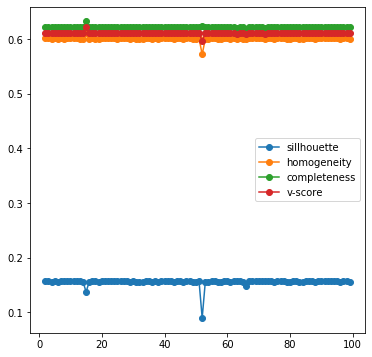

In [57]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sill, marker='o', label='sillhouette')
plt.plot(list_k, homo, marker='o', label='homogeneity')
plt.plot(list_k, com, marker='o', label='completeness')
plt.plot(list_k, v, marker='o', label='v-score')
plt.legend()

Silhouette score: 0.36823325145663854
Homogeneity: 0.602
Completeness: 0.623
V-measure: 0.612


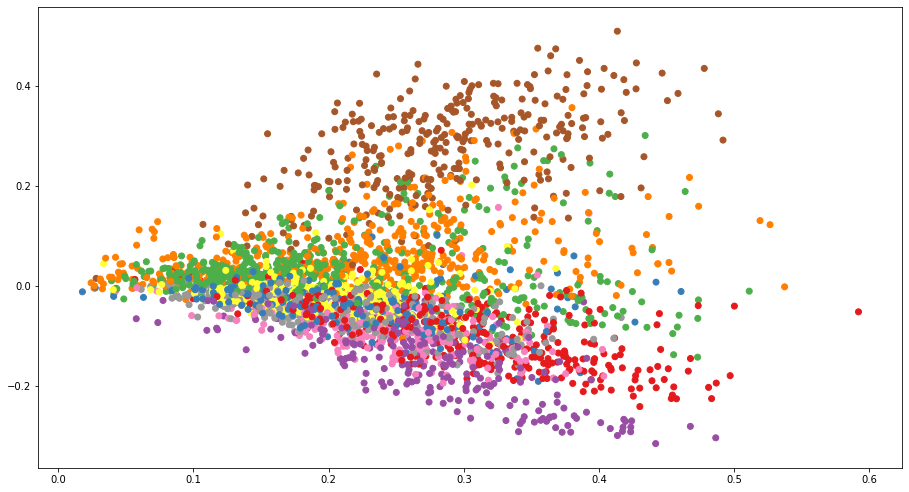

In [58]:
km = KMeans(n_clusters=len(cats), init='k-means++')
km.fit(X)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=sc.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(X, labels=km.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

Not a bad measure for homogeneity, completeness, and v-measure!  The silhouette score is about on par with what the models using embeddings produced.  Let's make some recommendations:

In [59]:
doc_id = random.randint(0, len(tagged_data) - 1)

print(f'Sample subreddit: {documents[doc_id][3]}')
print(f'Sample category: {documents[doc_id][1]}')

Sample subreddit: tech
Sample category: tech


Our sample post comes from r/tech.  Let's see what our types of posts our models recommend:

In [60]:
cluster = km.predict([X[doc_id]])[0]
same_cluster_index = np.where(km.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

photography
photography
photography
photography
photography
photography
photography
photography
games
games
pcgaming
pcgaming
pcgaming
ps4
ps4
xboxone
xboxone
xboxone
xboxone
xboxone
xboxone
xboxone
xboxone
xboxone
xboxone
guitar
guitar
Learnmusic
Learnmusic
news
news
news
worldnews
chemistry
physics
physics
physics
physics
futurology
futurology
futurology
futurology
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
gadgets
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
linux
li

This is a really mixed bag!  However, there area a ton of tech related subreddits in here.  Again, without really looking into the topic of each individual post it's hard to see what the similarity between these posts really is.